In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=43): 
        super(CustomCNN, self).__init__()
        
       
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  
        self.fc2 = nn.Linear(512, num_classes) 
        
    def forward(self, x):
       
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        
        x = x.view(-1, 128 * 8 * 8)  
        
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [2]:
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
import time

def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-3, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        print(f"Epoch {epoch+1} Time: {time.time() - start_time:.2f}s")
    
    # Load best model
    model.load_state_dict(best_model_state)
    return model


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class RoadSignDataset(Dataset):
    def __init__(self, img_dir, gt_file, transform=None):
        """
        Args:
            img_dir (string): Directory with all the image files.
            gt_file (string): Path to the ground truth annotations file.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.img_dir = img_dir
        self.gt_file = gt_file
        self.transform = transform
        
        
        self.annotations = self.load_annotations(gt_file)

    def load_annotations(self, gt_file):
        """
        Load annotations from the ground truth file.
        Each line in gt.txt contains: <image_filename>; <x_min>; <y_min>; <x_max>; <y_max>; <class_label>
        """
        annotations = []
        with open(gt_file, 'r') as f:
            for line in f:
                parts = line.strip().split(';')  
                
                
                if len(parts) < 6:
                    continue
                
                try:
                    img_name = parts[0]
                    bbox = list(map(int, parts[1:5]))  
                    label = int(parts[5])  
                    annotations.append((img_name, bbox, label))
                except ValueError:
                    
                    print(f"Skipping invalid line: {line.strip()}")
                    continue
        
        print(f"Loaded {len(annotations)} annotations from {gt_file}")  
        return annotations


    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name, bbox, label = self.annotations[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        
        img = Image.open(img_path)
        
        
        img = img.crop(bbox)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


In [ ]:

train_img_dir = 'D:/Work/DL/A3/ppm_images/train/images'
test_img_dir = 'D:/Work/DL/A3/ppm_images/test/images'
train_gt_file = 'D:/Work/DL/A3/ppm_images/train/gt_train.txt'
test_gt_file = 'D:/Work/DL/A3/ppm_images/test/gt_test.txt'


train_dataset = RoadSignDataset(img_dir=train_img_dir, gt_file=train_gt_file, transform=transform)
test_dataset = RoadSignDataset(img_dir=test_img_dir, gt_file=test_gt_file, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Loaded 681 annotations from D:/Work/DL/A3/ppm_images/train/gt_train.txt
Loaded 86 annotations from D:/Work/DL/A3/ppm_images/test/gt_test.txt


In [ ]:
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(30),      
    transforms.Resize((64, 64)),        
    transforms.ToTensor(),              
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = RoadSignDataset(img_dir=train_img_dir, gt_file=train_gt_file, transform=augmentations)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


Loaded 681 annotations from D:/Work/DL/A3/ppm_images/train/gt_train.txt


In [ ]:

model = CustomCNN(num_classes=43)  
trained_model = train_model(model, train_loader, test_loader, num_epochs=20, lr=1e-3, patience=5)


Epoch 1/20 - Train Loss: 3.3581, Validation Loss: 2.9545, Validation Accuracy: 0.2442
Epoch 1 Time: 51.00s
Epoch 2/20 - Train Loss: 2.6662, Validation Loss: 2.4106, Validation Accuracy: 0.2907
Epoch 2 Time: 3.89s
Epoch 3/20 - Train Loss: 2.1728, Validation Loss: 2.1096, Validation Accuracy: 0.2674
Epoch 3 Time: 3.60s
Epoch 4/20 - Train Loss: 1.8144, Validation Loss: 1.8040, Validation Accuracy: 0.4186
Epoch 4 Time: 3.56s
Epoch 5/20 - Train Loss: 1.6567, Validation Loss: 1.7663, Validation Accuracy: 0.4767
Epoch 5 Time: 3.49s
Epoch 6/20 - Train Loss: 1.4948, Validation Loss: 1.4048, Validation Accuracy: 0.5698
Epoch 6 Time: 3.46s
Epoch 7/20 - Train Loss: 1.3340, Validation Loss: 1.4251, Validation Accuracy: 0.5930
Epoch 7 Time: 2.95s
Epoch 8/20 - Train Loss: 1.1202, Validation Loss: 1.2353, Validation Accuracy: 0.5814
Epoch 8 Time: 3.53s
Epoch 9/20 - Train Loss: 0.9440, Validation Loss: 1.2547, Validation Accuracy: 0.5465
Epoch 9 Time: 3.36s
Epoch 10/20 - Train Loss: 0.8889, Validation 

Test Accuracy: 0.7907


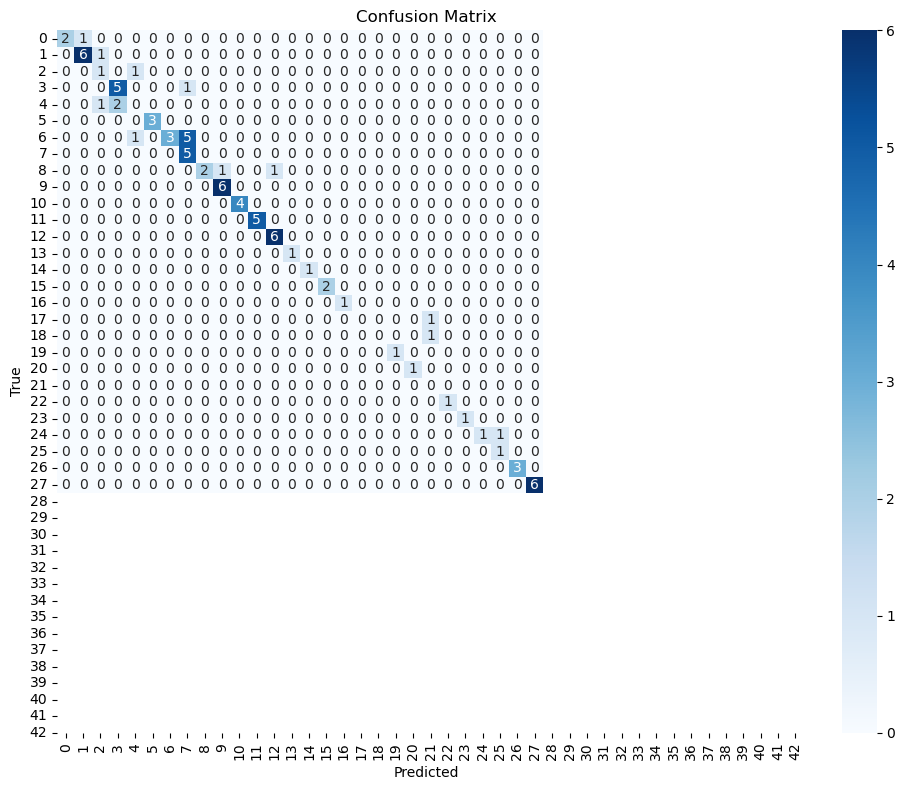

: 

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

    return all_labels, all_preds

def plot_confusion_matrix(all_labels, all_preds, num_classes=43):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def evaluate_and_plot(model, test_loader, num_classes=43, device=None):
    all_labels, all_preds = evaluate_model(model, test_loader, device)
    plot_confusion_matrix(all_labels, all_preds, num_classes)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  


evaluate_and_plot(model, test_loader, num_classes=43, device=device)
